## Setup

In [1]:
import numpy as np
import pandas as pd
#import keras
#from keras import layers
#from matplotlib import pyplot as plt
#import numpy as np
import matplotlib.pyplot as plt
#from cycler import cycler
import scipy.special as sp
import os as os
#import pywt as py
#import statistics as st
import os as os
#import random
import multiprocessing
from joblib import Parallel, delayed
#import platform
from time import time as ti
from skimage.restoration import denoise_wavelet
#import tensorflow as tf
import pickle
import CoreFunctions as cf

import sys

DataFolder = '/scratch/Recordings2/'
SaveFolder = '/scratch/750inputs/'
DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
SaveFolder = '/sciclone/scr10/dchendrickson01/Ninputs/'

StartPoint = 0
Groups = 180
#StartPoint = int(sys.argv[1])
#Groups = 186

verbose = True
small = False
noise = verbose

TIME_STEPS = 750
Skips = 50

tic = ti()
start = tic

In [2]:
def RollingStdDev(RawData, SmoothData, RollSize = 25):
    StdDevs = []
    for i in range(RollSize):
        Diffs = RawData[0:i+1]-SmoothData[0:i+1]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / (i+1)
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)
    for i in range(len(RawData)-RollSize-1):
        j = i + RollSize
        Diffs = RawData[i:j]-SmoothData[i:j]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / RollSize
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)  
    
    return StdDevs

def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs

    del Diffs
    
    Sqs = Sqs.tolist() 
    
    Sqs.extend(np.zeros(RollSize))
    
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    
    StdDevs = np.sqrt(VarVect)
    
    return StdDevs[:-RollSize]


def RollingSum(Data, Length = 100):
    RollSumStdDev = []
    for i in range(Length):
        RollSumStdDev.append(sum(Data[0:i+1]))
    for i in range(len(Data) - Length):
        RollSumStdDev.append(sum(Data[i:i+Length]))
    return RollSumStdDev

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def SquelchPatternFast(DataSet, StallRange = 5000, SquelchLevel = 0.02):
    SquelchSignal = np.ones(len(DataSet))

    #DataSet = DataSet.tolist() 
    
    DataSet.extend(np.zeros(StallRange))
    
    DSM = np.matrix(DataSet)
    
    for i in range(StallRange):
        DataSet.insert(0, DataSet.pop())
        DSM = np.concatenate((np.matrix(DataSet),DSM))
    
    DsmAvs = np.average(DSM,axis=0)
    
    DsmAvs[DsmAvs < SquelchLevel] = 0
    DsmAvs[DsmAvs >= SquelchLevel] = 1

    return SquelchSignal

def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if float(Timestamps[j]) > float(Timestamps[i]):
                dTime[j]=float(Timestamps[j])-float(Timestamps[i])
            else:
                dTime[j]=float(Timestamps[j])-float(Timestamps[i])+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

def MakeDTs(Seconds, Miliseconds):
    dts = np.zeros(len(Miliseconds), dtype=float)
    dts[0]=1
    for i in range(len(MiliSeconds)-1):
        j = i+1
        if Seconds[j]==Seconds[i]:
            dts[j]=Miliseconds[j]-Miliseconds[i]
        else:
            dts[j]=Miliseconds[j]-Miliseconds[i]+1000
    dts /= 10000
    return dts


def split_list_by_ones(original_list, ones_list):
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, goin to use fo rlong lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    for i in range(int((len(values) - time_steps + skips)/skips)):
        output.append(values[i*skips : (i*skips + time_steps)])
    return np.stack(output)

In [3]:
def runFile(file, verbose = False, small = False, index=0, start=ti()):
    noise = verbose
    if file[-4:] == '.csv':    
        dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')
        if noise:
            print("File Read", ti()-start)
        dataset = dataset.rename(columns={0:"Day"})
        dataset = dataset.rename(columns={1:"Second"})
        dataset = dataset.rename(columns={2:"FracSec"})
        dataset = dataset.rename(columns={3:"p"})
        dataset = dataset.rename(columns={4:"h"})
        dataset = dataset.rename(columns={5:"v"})
        dataset = dataset.rename(columns={6:"Sensor"})

        dataset['Second'].replace('',0)
        dataset['FracSec'].replace('',0)
        dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)
        
        dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
        dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))

        dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
        dataset["timestamps"] = dataset["timestamp"]

        dataset["p"] = dataset.p - np.average(dataset.p)
        dataset["h"] = dataset.h - np.average(dataset.h)
        dataset["v"] = dataset.v - np.average(dataset.v)
        dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)

        dataset.index = dataset.timestamp

        dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')

        if noise:
            print("Data Cleaned", ti()-start, len(dataset.p))

        RawData = dataset.v
        SmoothData = dataset.SmoothV
        RollSize = 25

        Diffs = RawData - SmoothData

        Sqs = Diffs * Diffs

        Sqs = Sqs.tolist() 

        Sqs.extend(np.zeros(RollSize))

        mSqs = np.matrix(Sqs)

        for i in range(RollSize):
            Sqs.insert(0, Sqs.pop())
            mSqs = np.concatenate((np.matrix(Sqs),mSqs))

        sVect = mSqs.sum(axis=0)
        eVect = (mSqs!=0).sum(axis=0)

        VarVect = sVect / eVect

        StdDevs = np.sqrt(VarVect)

        StdDevsZ = np.asarray(StdDevs)

        StdDevsZ=np.append(StdDevsZ,[0])

        StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])

        if noise:
            print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))

        #StdDevsZ = np.nan_to_num(StdDevsZ)

        #StdDevsZ[StdDevsZ == np.inf] = 0
        #StdDevsZ[StdDevsZ == -np.inf] = 0

        if noise:
            print("cleaned", ti()-start, np.shape(StdDevsZ))

        SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')

        if noise:
            print("denoise 1", ti()-start, np.shape(StdDevsZ))

        #SmoothDevZa = cf.Smoothing(StdDevsZ, 3, wvt='sym2', dets_to_remove=2, levels=3)
        #SmoothDevZ = np.ravel(SmoothDevZ[0,:])

        #SmoothDevZ = SmoothDevZ.tolist()

        if noise:
            print("denoise 2", ti()-start, np.shape(SmoothDevZ))

        #ataset["SmoothDevZ"] = SmoothDevZ

        SmoothDevZ[np.isnan(SmoothDevZ)]=0
        
        Max = np.max(SmoothDevZ)

        
        
        if noise:
            print("Max", ti()-start, np.shape(Max), Max)

        buckets = int(Max / 0.005) + 1
        bins = np.linspace(0,buckets*0.005,buckets+1)
        counts, bins = np.histogram(SmoothDevZ,bins=bins)

        CummCount = 0
        HalfWay = 0
        for i in range(len(counts)):
            CummCount += counts[i]
            if CummCount / len(SmoothDevZ) >= 0.5:
                if HalfWay == 0:
                    HalfWay = i

        SquelchLevel = bins[HalfWay] 
        if noise:
            print("SmoothDevz size", np.shape(SmoothDevZ))

        dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 4000, SquelchLevel, verbose=noise)

        if noise:
            print("Squelch Made", ti()-start)
        #dataset["velocity"] = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)
        #if noise:
        #    print("Velocity Calculated.  File done: ",file)

        df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
        df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
        df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)
        df_rrr = split_list_by_ones(dataset.r, dataset.IsMoving)
        df_ps = split_list_by_ones(dataset.SmoothP, dataset.IsMoving)
        df_hs = split_list_by_ones(dataset.SmoothH, dataset.IsMoving)
        df_vs = split_list_by_ones(dataset.SmoothV, dataset.IsMoving)
        df_rs = split_list_by_ones(dataset.SmoothR, dataset.IsMoving)

        if verbose:
            print("Split by ones", ti()-start)


        '''df_p=[0]
        df_h=[0]
        df_v=[0]
        df_r=[0]
        df_rp=[0]
        df_rh=[0]
        df_rv=[0]
        df_rr=[0]
        for i in range(len(df_ps)):
            df_p += df_ps[i]
            df_h += df_hs[i]
            df_v += df_vs[i]
            df_r += df_rs[i]
            df_rp += df_pr[i]
            df_rh += df_hr[i]
            df_rv += df_vr[i]
            df_rr += df_rrr[i]
        '''
        if verbose:
            print('format changed', ti()-start, np.shape(df_p))

        return df_pr, df_hr, df_vr, df_rrr, df_hs, df_ps, df_vs, df_rs
        
        
        #if verbose:
        #    print('Data normalized', ti()-start)

        #return df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr


In [4]:
files= os.listdir(DataFolder) 
#Results = Parallel(n_jobs=8)(delayed(runFile)(file, False, False, index) for index, file in enumerate(files))

In [5]:
%%time
df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr = runFile(files[3], verbose = False, small = False, index=0, start=ti())

CPU times: user 11min 33s, sys: 48.5 s, total: 12min 21s
Wall time: 12min 25s


In [6]:
print(len(df_p),len(df_h),len(df_v),len(df_r),
      len(df_rp),len(df_rh),len(df_rv),len(df_rr))

2303 2303 2303 2303 2303 2303 2303 2303


In [7]:
l_p= []
l_h = []
l_v = []
l_r = [] 
l_rp = []
l_rh = []
l_rv = [] 
l_rr = []

In [8]:
l_p.append(df_p)
l_h.append(df_h)
l_v.append(df_v)
l_r.append(df_r)
l_rp.append(df_rp)
l_rh.append(df_rh)
l_rv.append(df_rv)
l_rr.append(df_rr)

In [9]:
starts = ti()
for i in range(20):
    tdf_p, tdf_h, tdf_v, tdf_r, tdf_rp, tdf_rh, tdf_rv, tdf_rr = runFile(files[i*3+7], verbose = False, small = False, index=0, start=starts)
    l_p.append(tdf_p)
    l_h.append(tdf_h)
    l_v.append(tdf_v)
    l_r.append(tdf_r)
    l_rp.append(tdf_rp)
    l_rh.append(tdf_rh)
    l_rv.append(tdf_rv)
    l_rr.append(tdf_rr)
    print(i, int((ti()-starts)*100/60)/100, len(tdf_p))
    

0 6.06 417
1 15.0 109
2 18.9 406
4 31.55 1
5 41.5 595
6 51.1 72
7 60.31 1
8 74.4 1
9 82.08 333
10 88.47 266
11 88.61 15
12 95.67 1
13 102.51 403
14 113.81 822
15 124.84 654
16 136.58 6
17 151.11 385
18 155.44 212
19 169.04 632


In [14]:
lengths=[]
rejects=[]

In [15]:
for item in l_p:
    #print(len(item))
    for move in item:
        if (len(move) < 50000 and len(move) > 2500):
            lengths.append(len(move))
        else:
            rejects.append(len(move))

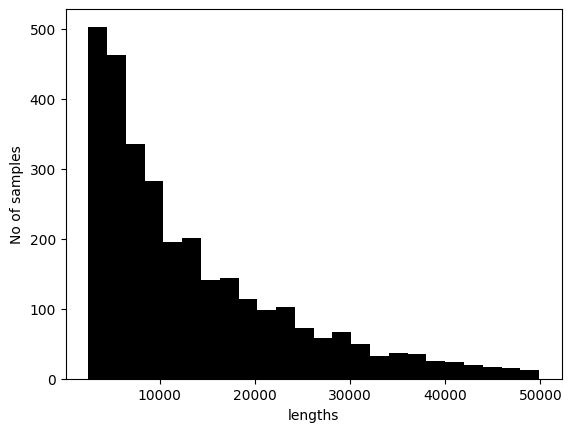

In [19]:
plt.hist(lengths, bins=24)
plt.xlabel("lengths")
plt.ylabel("No of samples")
plt.show()


In [ ]:
for i, item in enumerate(l_p):
    lengths.append(len(item))

In [11]:
max(lengths)


NameError: name 'lengths' is not defined

In [49]:
for i in range(20):
    tdf_p, tdf_h, tdf_v, tdf_r, tdf_rp, tdf_rh, tdf_rv, tdf_rr = runFile(files[i*3+6], verbose = False, small = False, index=0, start=starts)
    l_p.append(tdf_p)
    l_h.append(tdf_h)
    l_v.append(tdf_v)
    l_r.append(tdf_r)
    l_rp.append(tdf_rp)
    l_rh.append(tdf_rh)
    l_rv.append(tdf_rv)
    l_rr.append(tdf_rr)
    print(i, int((ti()-starts)*100)/6000, len(tdf_p))


0 1090.1291666666666 1
1 1099.0641666666668 227
2 1121.6613333333332 446
3 1135.4683333333332 968
4 1156.697 728
5 1171.0761666666667 685
6 1198.4765 860
7 1215.0765 68
8 1221.36 1
9 1241.3365 1
10 1255.1228333333333 1
11 1270.2233333333334 120
12 1290.6948333333332 377
13 1302.6723333333334 487
14 1333.5788333333333 1
15 1357.3946666666666 152
16 1382.2271666666666 1
17 1411.578 17
18 1434.7223333333334 1
19 1447.182 93


In [ ]:
for i in range(20):
    tdf_p, tdf_h, tdf_v, tdf_r, tdf_rp, tdf_rh, tdf_rv, tdf_rr = runFile(files[i*3+4], verbose = False, small = False, index=0, start=starts)
    l_p.append(tdf_p)
    l_h.append(tdf_h)
    l_v.append(tdf_v)
    l_r.append(tdf_r)
    l_rp.append(tdf_rp)
    l_rh.append(tdf_rh)
    l_rv.append(tdf_rv)
    l_rr.append(tdf_rr)
    print(i, int((ti()-starts)*100)/6000, len(tdf_p))


In [48]:
%%time 
tdf_p, tdf_h, tdf_v, tdf_r, tdf_rp, tdf_rh, tdf_rv, tdf_rr = runFile(files[4*3+5], verbose = False, small = False, index=0, start=starts)

CPU times: user 10min 6s, sys: 1min 45s, total: 11min 52s
Wall time: 11min 51s


In [ ]:
np.shape(l_p[1])


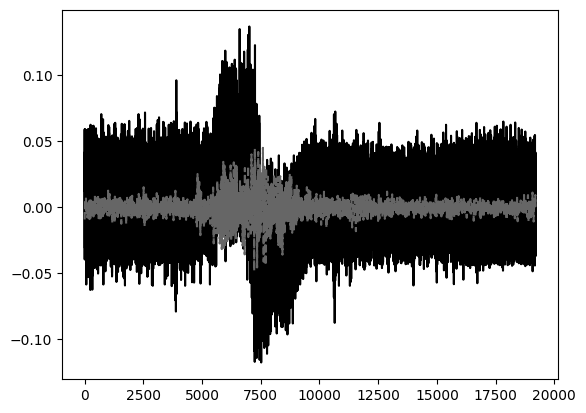

In [21]:
i=3
j=11

fig = plt.figure()
plt.plot(l_p[i][j])
plt.plot(l_rp[i][j])
plt.show()

In [ ]:
len(l_p[8])

In [35]:
lengths=[]
rejects=[]

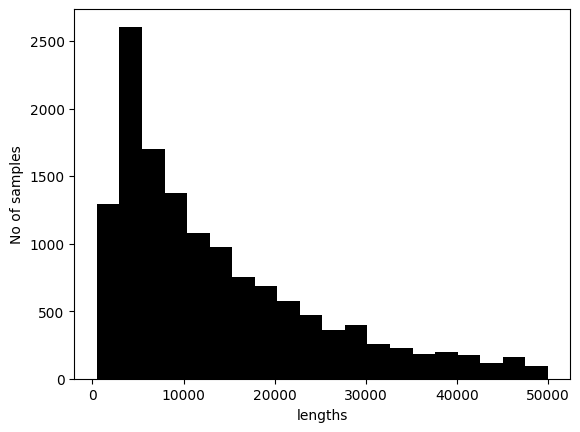

In [51]:
plt.hist(lengths, bins=20)
plt.xlabel("lengths")
plt.ylabel("No of samples")
plt.show()


In [17]:
len(lengths) / (len(lengths)+len(rejects))

0.39034076351524466

In [18]:
np.average(lengths)

13513.165736790286

groups = [2250-3000,6
          3001-5000, 10
          5001-7500, 25
          7501-10000, 20
          10001-15000, 30
          15001-20000, 40
          20001-30000, 60
          30001-50000, 100
          50001-75000, 150
          75001-100000] 200

In [ ]:
r6s=[]
r10s=[]
r15s=[]
r20d=[]
r30s=[]
r40s=[]
r60s=[]
r100s=[]
r150s=[]
r200s=[]

s6s=[]
s10s=[]
s15s=[]
s20d=[]
s30s=[]
s40s=[]
s60s=[]
s100s=[]
s150s=[]
s200s=[]



for i, item in enumerate(l_p):
    #print(len(item))
    for j, move in enumerarte(item):
        MvSize = len(move)
        if (MvSize > 2500 and MvSize <= 3000):
            temp = l_p[i][j]
        else:
           